In [44]:
%cd python

[WinError 2] The system cannot find the file specified: 'python'
C:\Users\kisha\Documents\LRP_Demo\python


# Notebook to play around the different threshold, digits and methods

In [45]:
import matplotlib.pyplot as plt
import time
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import model_io
import data_io
import render
# import cv2
import modules

In [46]:
def convertPixels_to_XY(pixels, dim=2):
    cord = []
    for pixel in pixels:
        y = pixel%32
        x = int(pixel/32)
        for i in range(3):
            for j in range(3):
                cord.append((3*x+i, 3*y+j))
    return cord

In [47]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../models/Mnist_cnn.txt') # 99.16% prediction accuracy
nn.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../models/Mnist_cnn.txt
removing softmax output mapping


In [48]:
nn_target = model_io.read('../models/Mnist_Emnist_cnn.txt') # 99.16% prediction accuracy
nn_target.drop_softmax_output_layer() #drop softnax output layer for analyses
nn_target.modules[6].name = "lbf"

loading plain text model from ../models/Mnist_Emnist_cnn.txt
removing softmax output mapping


In [49]:
X = data_io.read('../data/EMNIST/Emnist_test_images.npy')
Y = data_io.read('../data/EMNIST/Emnist_test_labels.npy')
X = np.array([x.T for x in X])

loading np-formatted data from ../data/EMNIST/Emnist_test_images.npy
loading np-formatted data from ../data/EMNIST/Emnist_test_labels.npy


In [50]:
# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

In [51]:
#reshape the vector representations in X to match the requirements of the CNN input
X = np.reshape(X,[X.shape[0],28,28,1])
X = np.pad(X,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))

In [52]:
# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y.astype(int) - 1
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

In [53]:
acc = np.mean(np.argmax(nn_target.forward(X), axis=1) == np.argmax(Y, axis=1))
if not np == numpy: # np=cupy
    acc = np.asnumpy(acc)
print('Target model test accuracy is: {:0.4f}'.format(acc))

Target model test accuracy is: 0.8291


In [54]:
#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])
#I = np.random.permutation(I)

In [55]:
#Select a Digit between 5-9
clas = 13
for i in I:
  if np.argmax(Y[i]) == clas:
    break


In [56]:
#Find Relevance using Base network

x = X[na,i,:]

#forward pass and prediction
ypred = nn.forward(x)
print('True label:     ', np.argmax(Y[i]))
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 0-4', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

R_base = []
#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
lrp_type = ["simple", "alphabeta", "epsilon", "ww"]
lrp_t = [1, 3, 0.01, 1]
for k in range(len(lrp_type)):
    R_base.append(nn.lrp(Rinit, lrp_type[k], lrp_t[k]))
    
    


#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    for k in range(len(lrp_type)):
        R_base[k] = np.asnumpy(R_base[k])

# print(len(R[0]))
#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_base = []
for k in range(len(lrp_type)):
    hm_base.append(render.hm_to_rgb(R_base[k], X = x, scaling = 3, sigma = 2))
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# # display the image as written to file
# plt.imshow(hm_base, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      13
Predicted label: 0 

Prediction Score 0-4 [[  6.44598098  -0.412945    -5.82414133  -6.86144979  -3.64914727
   -4.75709762 -10.71930041  -0.11775836  -1.54590973   3.52774845]]


In [57]:
#Find Relevance using Target network

x = X[na,i,:]

#forward pass and prediction
ypred = nn_target.forward(x)
print('True label:     ', np.argmax(Y[i]))
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 5-9', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
# R_target_0 = nn_target.lrp(Rinit,'simple', 3, reset=0)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
# print(R_target)
# print(max(R_target[0]), min(R_target[0]))
activations = nn_target.forward(x, lbfBreak=True)
activations = activations[0]
reset_values = [0, 1, 2, 3]
R_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        if lrp_type[k] == "alphabeta":
            epsilon = 4
        elif lrp_type[k] == "epsilon":
            epsilon = 0.01
        else:
            epsilon = 2
        R_target[lrp_type[k]].append(nn_target.lrp(Rinit, lrp_type[k], epsilon, reset_values[j], t_A=15, t_R=15, act=activations, net="cnn"))
        
        

#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)

#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        hm_target[lrp_type[k]].append(render.hm_to_rgb_2(R_target[lrp_type[k]][j], X = x, scaling = 3, sigma = 2))
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_target, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      13
Predicted label: 13 

Prediction Score 5-9 [[ 2.69740719 -3.12348    -0.90528181 -2.10986947 -4.08179492 -3.74068606
   0.61066849  1.07500764 -2.19943213 -5.11834899 -1.90200843 -1.08219938
   5.40508421  8.85450355  2.46734677  3.65985649  1.18993547  4.30471757
  -6.98216059 -5.50097978 -0.3529247   0.46382778 -3.62476451 -7.27197046
   2.81925844 -6.05478405]]
Breaking forward at layer -  6


In [58]:
for i in range(len(lrp_type)):
    R_base[i] = R_base[i].sum(axis=3)
    R_base[i] = R_base[i][0].reshape((1, 1024))[0]

for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        R_target[lrp_type[i]][j] = R_target[lrp_type[i]][j].sum(axis=3)
        R_target[lrp_type[i]][j] = R_target[lrp_type[i]][j][0].reshape((1, 1024))[0]


In [59]:
# Overlap Image
# r, g, b = cv2.split(hm)
# r2, g2, b2 = cv2.split(hm_target)

# t = 0.7

# threshold1 = max(R) * t
# threshold2 = max(R_target) * t


# #Dynamic threshold
# tmp = np.where(R > 0.1)
# threshold1 = np.mean(R[tmp])

# tmp = np.where(R_target > 0.1)
# threshold2 = np.mean(R_target[tmp])

#Top how many percent
t = 10
r = 0.
g = 1.
b = 0.

hm_overlap = []
commom_red_indices = []
hm_overlap_black = []
hm_overlap_black1 = []
hm_overlap_white = []
for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        target = int(1024 - 10.24*t)
        threshold1 = np.partition(R_target[lrp_type[i]][0], target)[target]
        threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

        indices1 = np.where(R_target[lrp_type[i]][0] > threshold1)

        indices2 = np.where(R_target[lrp_type[i]][j] > threshold2)


        common_red = np.intersect1d(indices1, indices2)
        commom_red_indices.append(common_red)
        
        R_overlap = np.zeros(1024)
        R_overlap[common_red] = 10 


#         target = int(7.84*t)
#         threshold1 = np.partition(R_target[lrp_type[i]][0], target)[target]
#         threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

#         indices1 = np.where(R_target[lrp_type[i]][0] < threshold1)

#         indices2 = np.where(R_target[lrp_type[i]][j] < threshold2)

#         common_blue = np.intersect1d(indices1, indices2)
        
#         R_overlap[common_blue] = -10 

        hm = render.hm_to_rgb(R_overlap, X = x, scaling = 3, sigma = 2)
        hm_overlap.append(hm)
        
        common_red2 = convertPixels_to_XY(common_red)
#         print(indices1)
        indices1_cord = convertPixels_to_XY(list(indices1[0]))
        
        tempImage = hm_target[lrp_type[i]][0].copy()
        tempImage1 = hm_target[lrp_type[i]][0].copy()
        
        tempImage2 = hm_target[lrp_type[i]][0].copy()
        
        for row in range(len(tempImage2)):
            for col in range(len(tempImage2[row])):
                if tempImage2[row][col][0] != 0 or tempImage2[row][col][1] != 0 or tempImage2[row][col][2] != 0:
                    tempImage2[row][col][0] = tempImage2[row][col][1] = tempImage2[row][col][2] = 1.
        
        for index in indices1_cord:
            tempImage2[index[0]][index[1]][0] = r
            tempImage2[index[0]][index[1]][1] = g
            tempImage2[index[0]][index[1]][2] = b
        
        for index in common_red2:
#             print(index[0], index[1])
            tempImage[index[0]][index[1]][0] = 0.
            tempImage[index[0]][index[1]][1] = 0.
            tempImage[index[0]][index[1]][2] = 0.
            
            tempImage1[index[0]][index[1]][0] = 1.
            tempImage1[index[0]][index[1]][1] = 1.
            tempImage1[index[0]][index[1]][2] = 1.
            
            tempImage2[index[0]][index[1]][0] = 1.
            tempImage2[index[0]][index[1]][1] = 0.
            tempImage2[index[0]][index[1]][2] = 0.
        
            
        hm_overlap_black.append(tempImage)
        hm_overlap_black1.append(tempImage1)
        hm_overlap_white.append(tempImage2)
        
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_overlap, interpolation = 'none')
# plt.axis('off')
# plt.show()

# plt.imshow(r2, interpolation = 'none')
# plt.axis('off')
# plt.show()


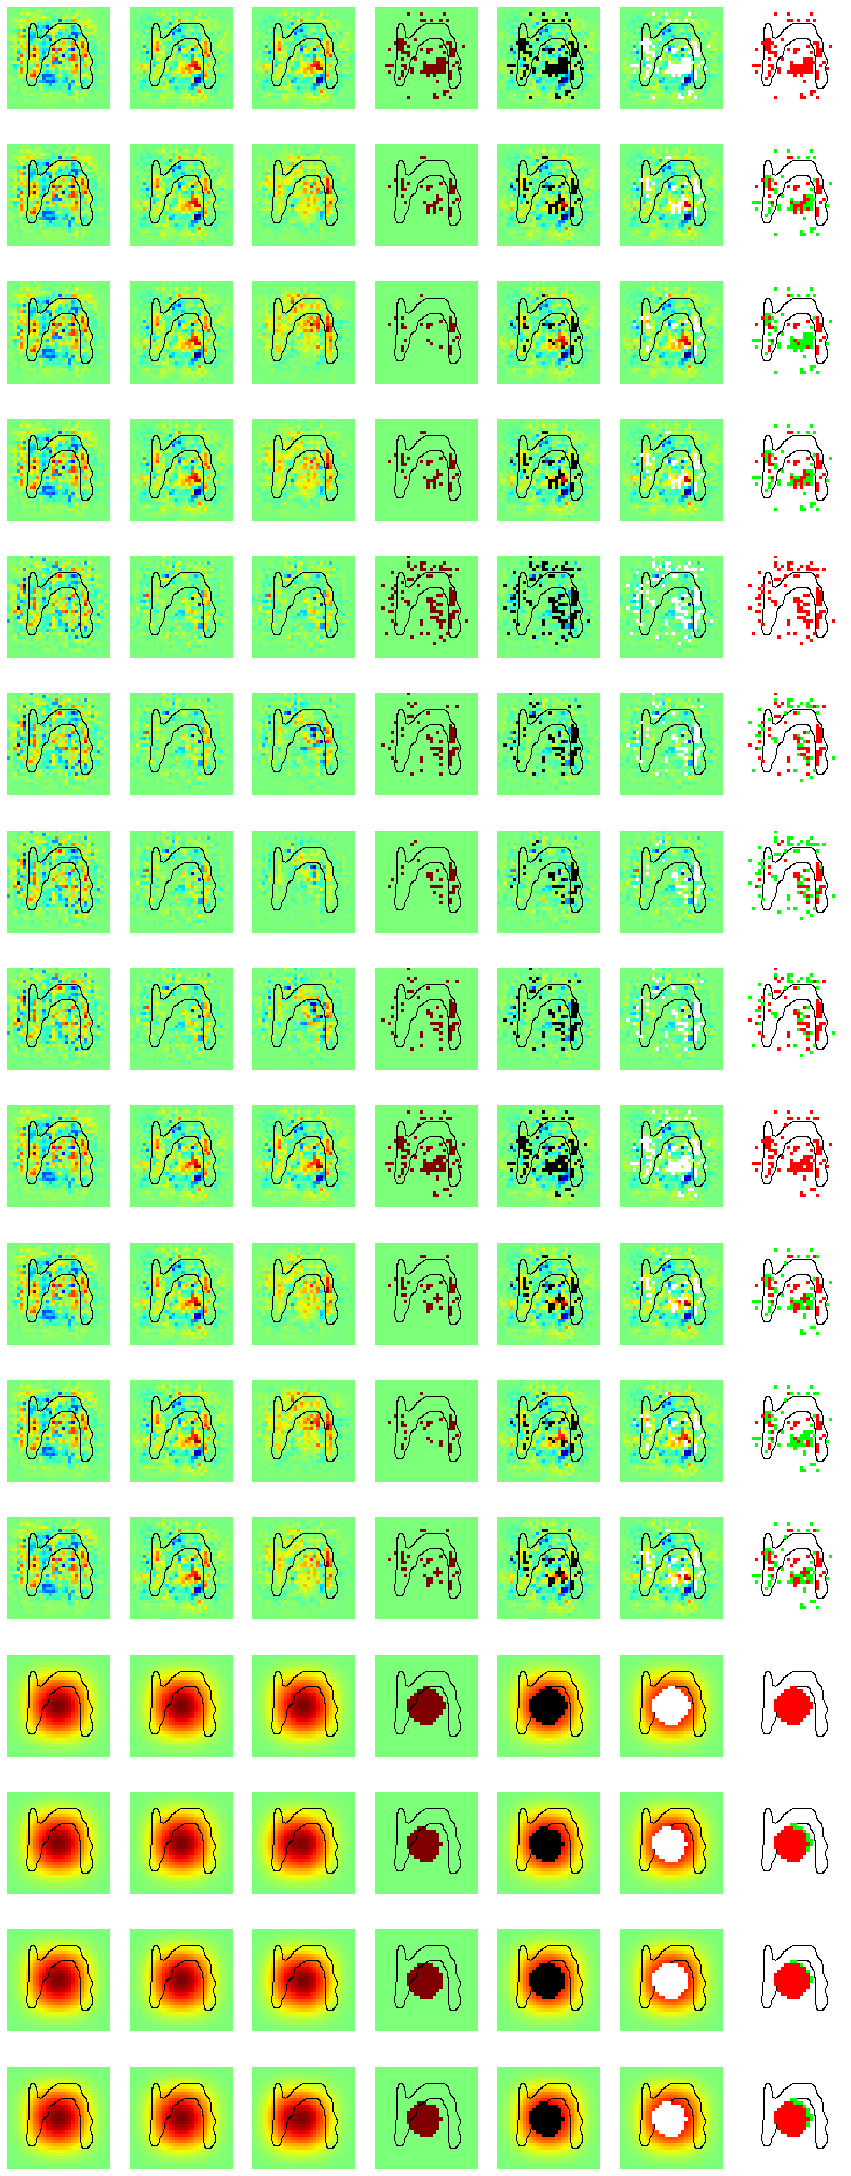

In [60]:

fig, grid = plt.subplots(16, 7, figsize=(15,40)) 


for i in range(len(lrp_type)*4):
#     if i%4 == 0:
#         print("LRP type - ", lrp_type[int(i/4)])
    for j in range(7):
        if(j==0):
            image = hm_base[int(i/4)]
        elif(j==1):
            image = hm_target[lrp_type[int(i/4)]][0]
        elif(j==3):
            image = hm_overlap[i]
        elif(j==2):
            image = hm_target[lrp_type[int(i/4)]][i%4]
        elif(j==4):
            image = hm_overlap_black[i]
        elif(j==5):
            image = hm_overlap_black1[i]
        else:
            image = hm_overlap_white[i]
        
            
        grid[i, j].imshow(image)
        grid[i, j].axis('off')
#     print("-------------------------------------------------")
